In [1]:
# Noah Venethongkham, 219660117
# Ashley Thor, 219334909
# Lucas Saechao, 218794239
# CSC 180 - Intelligent Systems

In [2]:
# matplotlib
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt

# numpy and pandas
import numpy as np
import pandas as pd
import multiprocessing

# scikit learn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import column_or_1d
import sklearn.feature_extraction.text as sk_text
import skimage.transform

# natural language toolkit
# run pip install nltk
from nltk.corpus import stopwords
import nltk

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

# tensorflow and keras
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Input, Dense, Activation, Flatten, Dropout, Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, Embedding
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# run pip install np_utils
from tensorflow.keras.utils import to_categorical

# python libraries
from collections.abc import Sequence
import requests
import pathlib
import shutil
import string
import json
import time
import csv
import io
import os
import re

nltk.download('stopwords')

C:\Users\Noah\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\Noah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Noah\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Noah\anaconda3\lib\site-packages\tens

True

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plots a confusion matrix for the model
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC curve
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_area_under_curve = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = $0.2f)' % roc_area_under_curve)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show
 
def text_to_word_list(text):
    text = str(text)
    text = text.lower()
    text = remove_stopwords(text)
    
    # clean text by regex
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=><]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\>", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\'", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", "\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"covid19", "covid", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub('_', ' ', text)
    return text

def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't", "not", "no"]
    words = text.split()
    words_clean = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(words_clean)
    
def remove_stop_manual(data):
    stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]
    data = data.apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data
    
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            current_word = w_line[0]
            word_to_vec_map[current_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map
    
def lstm_model(input_shape):
    x_indices = Input(input_shape)
    embeddings = embedding_layer(x_indices)
    x = LSTM(128, return_sequences=True)(embeddings)
    x = Dropout(0.2)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(128)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=x_indices, outputs=x)
    return model

def conv_model(input_shape):
    x_indices = Input(input_shape)
    embeddings = embedding_layer(x_indices)
    x = Conv1D(512, 3, activation='relu')(embeddings)
    x = MaxPooling1D(3)(x)
    x = Conv1D(256, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(256, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = MaxPooling1D(3)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=x_indices, outputs=x)
    return model
    
def predict_sentiments(data, corpus):
    data['sentiment score'] = 0
    corpus = pad_sequences(corpus, maxlen=max_len, padding='post')
    pred = convolution_model.predict(corpus)
    data['sentiment score'] = pred
    pred_sentiment = np.array(list(map(lambda x: 'positive' if x > 0.5 else 'negative', pred)))
    data['predicted sentiment'] = 0
    data['predicted sentiment'] = pred_sentiment
    return data

def predict_sentiments_lstm(data, corpus):
    data['sentiment score'] = 0
    corpus = pad_sequences(corpus, maxlen=max_len, padding='post')
    pred = lstm_model.predict(corpus)
    data['sentiment score'] = pred
    pred_sentiment = np.array(list(map(lambda x: 'positive' if x > 0.5 else 'negative', pred)))
    data['predicted sentiment'] = 0
    data['predicted sentiment'] = pred_sentiment
    return data
    
# Beep if on a windows machine
if os.name == 'nt':
    def ding():
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)
        winsound.Beep(2000, 300)

In [4]:
# Create pandas dataframe output file
df_reddit = pd.read_csv('reddit_vm.csv', encoding="utf-8")
df_reddit = df_reddit[['title', 'body', 'sentiment']].fillna('')
df_reddit['title'] = df_reddit['title'].replace(to_replace='Comment', value='')

print(df_reddit)

                                                  title  \
0     Health Canada approves AstraZeneca COVID-19 va...   
1     COVID-19 in Canada: 'Vaccination passports' a ...   
2     Coronavirus variants could fuel Canada's third...   
3     Canadian government to extend COVID-19 emergen...   
4     Canada: Pfizer is 'extremely committed' to mee...   
...                                                 ...   
1486                                                      
1487                                                      
1488                                                      
1489                                                      
1490                                                      

                                                   body sentiment  
0                                                        positive  
1                                                                  
2                                                                  
3                  

In [5]:
df_reddit.body = remove_stop_manual(df_reddit.body)
df_reddit.title = remove_stop_manual(df_reddit.title)

df_reddit.body = df_reddit.body.apply(remove_stopwords)
df_reddit.title = df_reddit.title.apply(remove_stopwords)
print(df_reddit)

                                                  title  \
0     Health Canada approves AstraZeneca COVID-19 va...   
1     COVID-19 Canada: 'Vaccination passports' near ...   
2         Coronavirus variants fuel Canada's third wave   
3     Canadian government extend COVID-19 emergency ...   
4     Canada: Pfizer 'extremely committed' meeting v...   
...                                                 ...   
1486                                                      
1487                                                      
1488                                                      
1489                                                      
1490                                                      

                                                   body sentiment  
0                                                        positive  
1                                                                  
2                                                                  
3                  

In [6]:
df_sentiment = df_reddit.sentiment
df_sentiment.replace('', 'negative', inplace=True)
df_sentiment

0       positive
1       negative
2       negative
3       negative
4       positive
          ...   
1486    positive
1487    negative
1488    positive
1489    positive
1490    negative
Name: sentiment, Length: 1491, dtype: object

In [7]:
df_title = df_reddit.title
df_title.replace('', np.nan, inplace=True)
df_title.to_frame(name="text")
df_body = df_reddit.body
df_body.to_frame(name="text")
df_body.replace('', np.nan, inplace=True)

In [8]:
df_title_sentiment = pd.concat([df_title, df_sentiment], axis=1)
df_title_sentiment

,title,sentiment
0,Health Canada approves AstraZeneca COVID-19 va...,positive
1,COVID-19 Canada: 'Vaccination passports' near ...,negative
2,Coronavirus variants fuel Canada's third wave,negative
3,Canadian government extend COVID-19 emergency ...,negative
4,Canada: Pfizer 'extremely committed' meeting v...,positive
...,...,...
1486,NaN,positive
1487,NaN,negative
1488,NaN,positive
1489,NaN,positive


In [9]:
df_body_sentiment = pd.concat([df_body, df_sentiment], axis=1)
df_body_sentiment

,body,sentiment
0,NaN,positive
1,NaN,negative
2,NaN,negative
3,NaN,negative
4,NaN,positive
...,...,...
1486,The problem calculations idea layperson napkin...,positive
1487,created Vaxfact site using references reliable...,negative
1488,>The information provided not wrong You've rep...,positive
1489,Basically nothing. >Autoimmunity central nervo...,positive


In [10]:
df_title_clean = df_title_sentiment.dropna().drop_duplicates().reset_index(drop=True)
df_title_clean

,title,sentiment
0,Health Canada approves AstraZeneca COVID-19 va...,positive
1,COVID-19 Canada: 'Vaccination passports' near ...,negative
2,Coronavirus variants fuel Canada's third wave,negative
3,Canadian government extend COVID-19 emergency ...,negative
4,Canada: Pfizer 'extremely committed' meeting v...,positive
...,...,...
445,father five unvaccinated children. Am unfit pa...,negative
446,Love Them. Protect Them. Never Inject Them.,negative
447,Vaccines Are Just Asping For Trouble,negative
448,Dr. Harper explained presentation cervical can...,negative


In [11]:
df_body_clean = df_body_sentiment.dropna().drop_duplicates().reset_index(drop=True)
df_body_clean

,body,sentiment
0,Your OP. It's not myth. Only one vaccine conta...,negative
1,https://youtu.be/zBkVCpbNnkU,positive
2,Because Anti-Vaxxers no sense,positive
3,"What mean ""your OP"". fairly new reddit.",negative
4,"When say no thimerasol, mean childhood schedul...",negative
...,...,...
1093,The problem calculations idea layperson napkin...,positive
1094,created Vaxfact site using references reliable...,negative
1095,>The information provided not wrong You've rep...,positive
1096,Basically nothing. >Autoimmunity central nervo...,positive


In [12]:
df_corpus = pd.DataFrame(index=range(0, 1524), columns=['text', 'sentiment'], dtype='object')
df_corpus_text = pd.concat([df_title_clean.title, df_body_clean.body])
df_corpus_sentiment = pd.concat([df_title_clean.sentiment, df_body_clean.sentiment])
df_corpus_text = df_corpus_text.to_frame(name='text')
df_corpus_text.reset_index(inplace=True)
df_corpus_sentiment = df_corpus_sentiment.to_frame(name='sentiment')
df_corpus_sentiment.reset_index(inplace=True)
df_corpus.text = df_corpus_text.text
df_corpus.sentiment = df_corpus_sentiment.sentiment

In [13]:
df_corpus.head()

,text,sentiment
0,Health Canada approves AstraZeneca COVID-19 va...,positive
1,COVID-19 Canada: 'Vaccination passports' near ...,negative
2,Coronavirus variants fuel Canada's third wave,negative
3,Canadian government extend COVID-19 emergency ...,negative
4,Canada: Pfizer 'extremely committed' meeting v...,positive


In [14]:
df_corpus.text = df_corpus.text.apply(lambda x: text_to_word_list(x))

In [15]:
texts = df_corpus.text
sentiments = df_corpus.sentiment

In [16]:
corpus_list = []
for i in range(len(texts)):
    corpus_list.append(texts[i])

In [17]:
# Convert sentiment from string to data in the binary form of 1 to 0
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentiments)))

In [18]:
y

array([1, 0, 0, ..., 0, 1, 0])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(corpus_list, y, test_size=0.3, random_state=45)

In [20]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

1066
458
1066
458


In [21]:
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(x_train)
word_to_index = tokenizer.word_index

In [22]:
glove_file_loc = os.path.join(
    os.path.expanduser('~'), '.keras/datasets/glove.6B.300d.txt'
)
word_to_vec_map = read_glove_vector(glove_file_loc)

In [23]:
max_len = 150

In [24]:
vocab_len = len(word_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]
emb_matrix = np.zeros((vocab_len + 1, embed_vector_len))
print(vocab_len)
print(embed_vector_len)
print(emb_matrix.shape)

6307
300
(6308, 300)


In [25]:
for word, index in word_to_index.items():
    embedding_vec = word_to_vec_map.get(word)
    if embedding_vec is not None:
        emb_matrix[index, :] = embedding_vec

In [26]:
embedding_layer = Embedding(
    input_dim=vocab_len + 1,
    output_dim=embed_vector_len,
    input_length=max_len,
    weights=[emb_matrix],
    trainable=False
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
model = lstm_model((max_len,))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          1892400   
_________________________________________________________________
lstm (LSTM)                  (None, 150, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 128)          0         
_________

In [28]:
convolution_model = conv_model((max_len,))
convolution_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          1892400   
_________________________________________________________________
conv1d (Conv1D)              (None, 148, 512)          461312    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 49, 512)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 47, 256)           393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 256)           1968

In [29]:
x_train_indices = tokenizer.texts_to_sequences(x_train)

In [30]:
x_train_indices = pad_sequences(x_train_indices, maxlen=max_len, padding='post')
print(x_train_indices.shape)

(1066, 150)


In [31]:
x_test_indices = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(x_test_indices, maxlen=max_len, padding='post')

In [32]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
convolution_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [33]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=2, mode='auto')
checkpoint = ModelCheckpoint(filepath="best_weights_conv1d.hdf5", verbose=0, save_best_only=True)

In [34]:
# Conv1D model
convolution_model.fit(x_train_indices, y_train, batch_size=64, callbacks=[monitor, checkpoint], epochs=15, validation_data=(x_test_indices, y_test))

Train on 1066 samples, validate on 458 samples
Epoch 1/15
1066/1066 [==============================] - 8s 7ms/sample - loss: 0.5476 - acc: 0.8377 - val_loss: 0.5072 - val_acc: 0.8231
Epoch 2/15
1066/1066 [==============================] - 0s 355us/sample - loss: 0.4786 - acc: 0.8293 - val_loss: 0.4896 - val_acc: 0.8231
Epoch 3/15
1066/1066 [==============================] - 0s 293us/sample - loss: 0.4474 - acc: 0.8377 - val_loss: 0.4865 - val_acc: 0.8231
Epoch 4/15
1066/1066 [==============================] - 0s 269us/sample - loss: 0.4139 - acc: 0.8377 - val_loss: 0.4762 - val_acc: 0.8231
Epoch 5/15
1066/1066 [==============================] - 0s 207us/sample - loss: 0.3844 - acc: 0.8386 - val_loss: 0.4705 - val_acc: 0.8231
Epoch 6/15
1066/1066 [==============================] - 0s 164us/sample - loss: 0.3615 - acc: 0.8518 - val_loss: 0.4978 - val_acc: 0.7860
Epoch 7/15
1066/1066 [==============================] - 0s 160us/sample - loss: 0.3190 - acc: 0.8762 - val_loss: 0.4729 - val_a

In [35]:
convolution_model.load_weights('best_weights_conv1d.hdf5')

In [36]:
# LSTM model
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=10, verbose=2, mode='auto')
checkpoint = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True)

model.fit(x_train_indices, y_train, batch_size=64, callbacks=[monitor, checkpoint], epochs=15, validation_data=(x_test_indices, y_test))

model.load_weights('best_weights_lstm.hdf5')

Train on 1066 samples, validate on 458 samples
Epoch 1/15
1066/1066 [==============================] - 15s 14ms/sample - loss: 0.6855 - acc: 0.8340 - val_loss: 0.6745 - val_acc: 0.8231
Epoch 2/15
1066/1066 [==============================] - 14s 13ms/sample - loss: 0.6535 - acc: 0.8377 - val_loss: 0.6234 - val_acc: 0.8231
Epoch 3/15
1066/1066 [==============================] - 13s 12ms/sample - loss: 0.5428 - acc: 0.8377 - val_loss: 0.4917 - val_acc: 0.8231
Epoch 4/15
1066/1066 [==============================] - 13s 12ms/sample - loss: 0.4602 - acc: 0.8377 - val_loss: 0.4709 - val_acc: 0.8231
Epoch 5/15
1066/1066 [==============================] - 13s 12ms/sample - loss: 0.4411 - acc: 0.8396 - val_loss: 0.4633 - val_acc: 0.8231
Epoch 6/15
1066/1066 [==============================] - 14s 14ms/sample - loss: 0.4363 - acc: 0.8443 - val_loss: 0.4636 - val_acc: 0.8231
Epoch 7/15
1066/1066 [==============================] - 15s 14ms/sample - loss: 0.4316 - acc: 0.8443 - val_loss: 0.4626 - val

In [37]:
# x_test_indices = tokenizer.texts_to_sequences(x_test)
# x_test_indices = pad_sequences(x_test_indices, maxlen=max_len, padding='post')

In [38]:
model.evaluate(x_test_indices, y_test)

458/458 [==============================] - 5s 11ms/sample - loss: 0.4616 - acc: 0.8231


[0.46160733075121085, 0.8231441]

In [39]:
convolution_model.evaluate(x_test_indices, y_test)

458/458 [==============================] - 0s 175us/sample - loss: 0.4572 - acc: 0.8166


[0.457215733663484, 0.8165939]

# Perform CNN predictions

In [40]:
predictions = convolution_model.predict(x_test_indices)

In [41]:
n = np.random.randint(0, len(x_test))
x_test[n]

'podcast discussing vaccinations need help ! '

In [42]:
if predictions[n] > 0.5:
    print('predicted sentiment is positive')
else:
    print('predicted sentiment is negative')
    
if y_test[n] == 1:
    print('correct sentiment is positive')
else:
    print('correct sentiment is negative')

predicted sentiment is negative
correct sentiment is positive


In [43]:
print(predictions[n])
print(y_test[n])

[0.3011142]
1


In [44]:
convolution_model.save_weights('best_weights_conv1d.hdf5')

In [45]:
corpus_tokens = tokenizer.texts_to_sequences(corpus_list)

In [46]:
data = df_corpus
data = predict_sentiments(data, corpus_tokens)

In [47]:
data[['text', 'sentiment', 'sentiment score', 'predicted sentiment']].to_csv('cnn_prediction.csv', index=False)

In [48]:
data

,text,sentiment,sentiment score,predicted sentiment
0,health canada approves astrazeneca covid - 19 ...,positive,0.387547,negative
1,covid - 19 canada : vaccination passports near...,negative,0.068375,negative
2,coronavirus variants fuel canada third wave,negative,0.028369,negative
3,canadian government extend covid - 19 emergenc...,negative,0.096703,negative
4,canada : pfizer extremely committed meeting va...,positive,0.706440,positive
...,...,...,...,...
1519,still 100 000 deaths measles every year world ...,negative,0.063665,negative
1520,qualifies something toxin ppb even ppm toxins ...,negative,0.082826,negative
1521,answer question said cannot cause damage body ...,negative,0.092884,negative
1522,yeah long time ago vaccines weren t safe today...,positive,0.299412,negative


In [49]:
# making predictions over the entire dataset
corpus_tokens = pad_sequences(corpus_tokens, maxlen=max_len, padding='post')
corpus_predictions = convolution_model.predict(corpus_tokens)
print(corpus_predictions)

[[0.3875471 ]
 [0.06837532]
 [0.02836946]
 ...
 [0.09288406]
 [0.29941165]
 [0.08888111]]


In [50]:
# converting the predictions to binary, 1=pos, 0=neg
binary_pred = []
for i in corpus_predictions:
    if i >= .5:
        i = 1 
        binary_pred.append(i) 
    else:
        i = 0
        binary_pred.append(i)

# CNN Model Evaluation
As a classification model, this model will be evaluated on the following metrics: 
 * Accuracy
 * Precision
 * Recall
 * F1 Score
 * Log Loss
 * Confusion Matrix
 * ROC Curve

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good. Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $

In [51]:
# Measure MSE error.  
score = metrics.mean_squared_error(binary_pred,y)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.07677165354330709


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [53]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(binary_pred,y))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.277076981258471


In [54]:
score = metrics.accuracy_score(y, binary_pred)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y, binary_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

#accuracy, precision, recall, f1 score
print(metrics.classification_report(y, binary_pred))

#log loss
logLoss = metrics.log_loss(y, binary_pred)
print('Log Loss: {}'.format(logLoss))

Accuracy: 0.9232283464566929
Averaged F1: 0.914750899445088
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1270
           1       0.96      0.56      0.71       254

    accuracy                           0.92      1524
   macro avg       0.94      0.78      0.83      1524
weighted avg       0.93      0.92      0.91      1524

Log Loss: 2.6516021232212155


[[1264    6]
 [ 111  143]]
Plotting confusion matrix


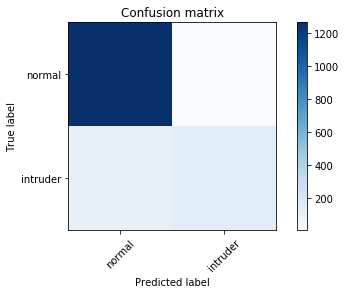

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1270
           1       0.96      0.56      0.71       254

    accuracy                           0.92      1524
   macro avg       0.94      0.78      0.83      1524
weighted avg       0.93      0.92      0.91      1524



In [55]:
# Compute confusion matrix
cm = confusion_matrix(y, binary_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()

print(classification_report(y, binary_pred))

# Perform LSTM predictions

In [56]:
# making predictions over the entire dataset
corpus_tokens = pad_sequences(corpus_tokens, maxlen=max_len, padding='post')
corpus_lstm_predictions = model.predict(corpus_tokens)
print(corpus_lstm_predictions)
len(corpus_lstm_predictions)

[[0.16953546]
 [0.16953695]
 [0.16953436]
 ...
 [0.16953605]
 [0.16953212]
 [0.16953436]]


1524

In [57]:
# converting the predictions to binary, 1=pos, 0=neg
binary_pred2 = []
for i in corpus_lstm_predictions:
    if i >= .5:
        i = 1 
        binary_pred2.append(i) 
    else:
        i = 0
        binary_pred2.append(i)

# Evaluating LSTM Model

### Mean Square Error

The mean square error is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit.  If an MSE value has decreased for a model, that is good. Low MSE values are desired.

$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $

In [58]:
# Measure MSE error.  
score = metrics.mean_squared_error(binary_pred2,y)
print("Final score (MSE): {}".format(score))

Final score (MSE): 0.16141732283464566


### Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE.  Because of this, the RMSE error is in the same units as the training data outcome. Low RMSE values are desired.

$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $

In [59]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(binary_pred2,y))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.4017677473798085


In [60]:
score1 = metrics.accuracy_score(y, binary_pred2)
print('Accuracy: {}'.format(score))

f1 = metrics.f1_score(y, binary_pred2, average='weighted')
print('Averaged F1: {}'.format(f1))

#accuracy, precision, recall, f1 score
print(metrics.classification_report(y, binary_pred2))

#log loss
logLoss = metrics.log_loss(y, binary_pred2)
print('Log Loss: {}'.format(logLoss))

Accuracy: 0.4017677473798085
Averaged F1: 0.7710619122257052
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1270
           1       0.90      0.04      0.07       254

    accuracy                           0.84      1524
   macro avg       0.87      0.52      0.49      1524
weighted avg       0.85      0.84      0.77      1524

Log Loss: 5.575157344321168


[[1269    1]
 [ 245    9]]
Plotting confusion matrix


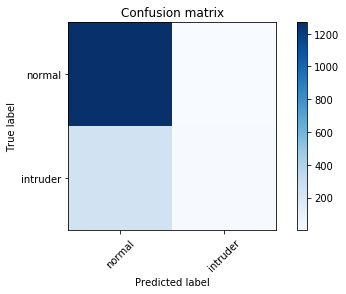

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1270
           1       0.90      0.04      0.07       254

    accuracy                           0.84      1524
   macro avg       0.87      0.52      0.49      1524
weighted avg       0.85      0.84      0.77      1524



In [61]:
# Compute confusion matrix
cm = confusion_matrix(y, binary_pred2)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, ['normal','intruder'])
plt.show()

print(classification_report(y, binary_pred2))